In [2]:
import random
import math
import numpy as np

from math import sin, cos, acos

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, Aer

import qiskit.ignis.verification.randomized_benchmarking as rb

IBMQ.load_account()

Failed to import duecredit due to No module named 'duecredit'
/home/alan/aur/miniconda3/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "
/home/alan/aur/miniconda3/lib/python3.8/site-packages/qinfer/parallel.py:61: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_unitary as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

In [4]:
def random_circuit(n_qubits):
    length_vector = [1]
    n_seeds = 1
    
    initial_list = list(range(0, n_qubits))    
    rb_pattern = []
    
    while len(initial_list) > 1:
        sample = random.sample(initial_list, 2)
        [initial_list.remove(i) for i in sample]
        rb_pattern.append(sample)
    
    if len(initial_list) == 1:
        rb_pattern.append([initial_list[0]])
    
    
    circuit, xdata = rb.randomized_benchmarking_seq(
        length_vector = [1],
        nseeds = 1,
        rb_pattern = rb_pattern
        )
    circuit = circuit[0][0]
    cregs = circuit.cregs
    
    circuit.remove_final_measurements(inplace=True)
    circuit.cregs = cregs
    
    for i in range(n_qubits):
        circuit.barrier(i)
        if (round(random.random())):
            circuit.x(i)
            circuit.barrier(i)
    
    return circuit

In [83]:
# Only one qubit for now
def design_circuit(n_qubits, unitary_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    if unitary_arr is not None:
        circuit.rx(unitary_arr[0], 0)
        circuit.rz(unitary_arr[1], 0)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

In [13]:
circuit = random_circuit(1)
circuit.draw()

┌───┐┌─────┐┌───┐ ░ ┌───┐┌───┐┌───┐ ░ ┌───┐ ░ 
qr_0: ┤ H ├┤ SDG ├┤ H ├─░─┤ H ├┤ S ├┤ H ├─░─┤ X ├─░─
      └───┘└─────┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ 
cr_0: ══════════════════════════════════════════════

In [82]:
def uniform_distribution(n_points):
        
#         n_points_x = int(pow(n_points / 2, 0.5)))
#         n_points_y = 2 * n_points_x
        points = []
        n_points_eff = int(pow(n_points, 0.5))
    
        for x in np.linspace(-np.pi, np.pi, n_points_eff):
            for y in np.linspace(-np.pi, np.pi, n_points_eff):
                yield [x, y]

In [46]:
x = uniform_distribution(20)

In [50]:
circuit_baseline = copy.deepcopy(circuit)
circuit_flip = copy.deepcopy(circuit)

circuit_flip.x(0)

circuit_baseline.measure([0],[0])
circuit_flip.measure([0],[0])

In [52]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_vigo')

In [53]:
circuit_baseline.draw()
job = execute(circuit_baseline, backend, shots=4096)
result = job.result()
outcome_baseline = result.get_counts(circuit_baseline)

In [54]:
circuit_flip.draw()
job = execute(circuit_flip, backend, shots=4096)
result = job.result()
outcome_flip = result.get_counts(circuit_flip)

In [84]:
results = []
results_x = []
results_y = []

n_points = 200
n_qubits = 1

for gate in uniform_distribution(n_points):
    
    results_x.append(gate[0])
    results_y.append(gate[1])
    
    tmp_circuit = copy.deepcopy(circuit)
    tmp_circuit = design_circuit(n_qubits, gate, circuit=tmp_circuit)

    job = execute(tmp_circuit, backend, shots=4096)

    result = job.result()
    results.append(job.result())

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


In [85]:
hues = [int(max(zip(i.get_counts().values(), i.get_counts().keys()))[1]) for i in results]

In [130]:
?plt.legend

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

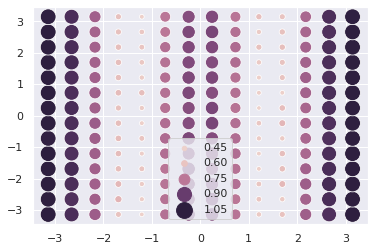

In [168]:
weights = [max(i.get_counts().values()) / 4096 for i in results]
sbs.scatterplot(x=results_x, y=results_y, size=weights, sizes=(20, 250), hue=weights)
plt._remove_legend(plt.legend)
plt._axes.xlabel('$\Theta$')
plt._axes.ylabel('$\phi$')
plt.title('Single Qubit State Reporting Rates')

plt.savefig('figs/unitary_demo.pdf')

In [136]:
w_arr = np.array(weights)

In [137]:
w_arr.shape

(196,)

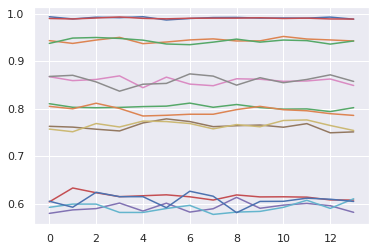

In [144]:
plt.plot(np.array(weights).reshape(14, 14).T)

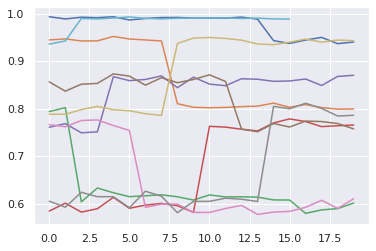

In [110]:
for i in range(18):
    curr_slice = weights[i * 20 : (i+1) * 20]
    plt.plot(curr_slice)

In [170]:
dist

NameError: name 'dist' is not defined